In [1]:
# 0) importing useful libraries
import pandas as pd
from datetime import time, datetime
import numpy as np
import seaborn as sns

In [2]:
# 1) loading dataset parsing dates
def int_to_hours(k):
    if k == "":
        return np.nan
    val = int(k) 
    hour = (val//100) % 24
    minute = (val % 100) % 60
    return time(hour=hour, minute=minute)

converters = {
    "DEP_TIME": int_to_hours,
    "CRS_DEP_TIME": int_to_hours,
    "WHEELS_OFF": int_to_hours,
    "WHEELS_ON": int_to_hours,
    "ARR_TIME": int_to_hours,
    "CRS_ARR_TIME": int_to_hours
}
ds = pd.read_csv("../datasets/flight_delay.csv", parse_dates=[0], converters=converters)
ds.drop(ds.columns[32], axis=1, inplace=True)

In [3]:
# 2) analyze records distribution
ds.info()
ds.describe(datetime_is_numeric=True)
# date interval: 2017-01-01 - 2017-01-31
no_airports = pd.concat([ds["ORIGIN_AIRPORT_ID"], ds["DEST_AIRPORT_ID"]]).drop_duplicates().count()
print(no_airports)
# 298 airports
no_carriers = ds["UNIQUE_CARRIER"].drop_duplicates().count()
print(no_carriers)
# 12 carriers
# missing values in TAIL_NUM, DEP_DELAY, DEP_TIME, TAXI_OUT, WHEELS_OFF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FL_DATE                450017 non-null  datetime64[ns]
 1   UNIQUE_CARRIER         450017 non-null  object        
 2   AIRLINE_ID             450017 non-null  int64         
 3   TAIL_NUM               449378 non-null  object        
 4   FL_NUM                 450017 non-null  int64         
 5   ORIGIN_AIRPORT_ID      450017 non-null  int64         
 6   ORIGIN_AIRPORT_SEQ_ID  450017 non-null  int64         
 7   ORIGIN_CITY_MARKET_ID  450017 non-null  int64         
 8   ORIGIN                 450017 non-null  object        
 9   ORIGIN_CITY_NAME       450017 non-null  object        
 10  DEST_AIRPORT_ID        450017 non-null  int64         
 11  DEST_AIRPORT_SEQ_ID    450017 non-null  int64         
 12  DEST_CITY_MARKET_ID    450017 non-null  int6

In [4]:
# 3) filter out all cancelled flights
total = len(ds.index)
ds = ds[ds["CANCELLED"] == 0]
cancelled = total - len(ds.index)
print("Total: ", total)
print("Cancelled: ", cancelled)

Total:  450017
Cancelled:  8886


In [5]:
# 4) count flights for each carrier
print(ds.groupby("UNIQUE_CARRIER").size())
# usando .count() conta tutte le colonne

# compute average delay for each carrier considering all possible reasons
print(ds.groupby("UNIQUE_CARRIER")["ARR_DELAY"].mean())

UNIQUE_CARRIER
AA     72152
AS     14454
B6     24077
DL     69031
EV     33878
F9      7598
HA      6258
NK     12129
OO     48266
UA     42171
VX      5645
WN    105472
dtype: int64
UNIQUE_CARRIER
AA     3.307004
AS     3.311553
B6     8.423231
DL     4.305279
EV    13.173011
F9    12.076791
HA     3.617181
NK     8.993642
OO    12.528524
UA     4.911975
VX    15.565912
WN     6.764571
Name: ARR_DELAY, dtype: float64


In [6]:
# 5) add weekday and delaydelta columns
ds.loc[:, "weekday"] = ds["FL_DATE"].dt.dayofweek
ds.loc[:, "delaydelta"] = ds["ARR_DELAY"] - ds["DEP_DELAY"]

<AxesSubplot:xlabel='weekday'>

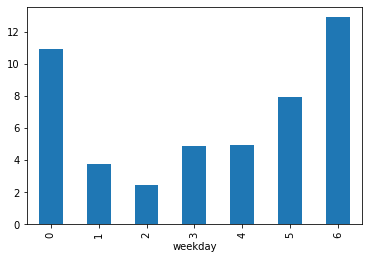

In [7]:
# 6) correlation between weekday and arrival delay correlation
ds.groupby("weekday")["ARR_DELAY"].mean().plot(kind='bar')
# on sunday the delay is higher

<AxesSubplot:title={'center':'weekend delays'}, xlabel='UNIQUE_CARRIER'>

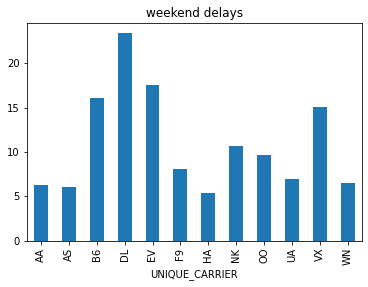

In [8]:
# 7) weekend delay for each carrier
# NB: in masking you must use bitwise operators & | ~
ds_weekend = ds.loc[(ds["weekday"] == 5) | (ds["weekday"] == 6)]
ds_weekend.groupby("UNIQUE_CARRIER")["ARR_DELAY"].mean().plot(kind='bar', title="weekend delays")

<AxesSubplot:title={'center':'workdays delays'}, xlabel='UNIQUE_CARRIER'>

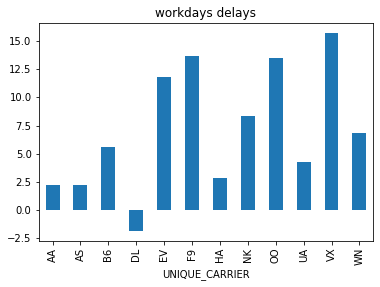

In [9]:
# 7) workdays delay for each carrier
ds_workdays = ds.loc[ds["weekday"] < 5]
ds_workdays.groupby("UNIQUE_CARRIER")["ARR_DELAY"].mean().plot(kind='bar', title="workdays delays")

In [10]:
# 8) create dataframe with multi-index composed by columns UNIQUE_CARRIER, ORIGIN, DEST, FL_DATE
ds_multi_index = ds.set_index(["UNIQUE_CARRIER", "ORIGIN", "DEST", "FL_DATE"])
ds_multi_index.index.names=["UNIQUE_CARRIER", "ORIGIN", "DEST", "FL_DATE"]
ds_multi_index.sort_index()

AIRLINE_ID TAIL_NUM  FL_NUM  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                                   
AA             ABQ    DFW  2017-01-01       19805   N4XSAA    1282   
                           2017-01-01       19805   N3NRAA    2611   
                           2017-01-01       19805   N4WNAA    2402   
                           2017-01-02       19805   N4XKAA    2611   
                           2017-01-02       19805   N4XBAA    2402   
...                                           ...      ...     ...   
WN             TUS    SAN  2017-01-29       19393   N570WN    2807   
                           2017-01-30       19393   N650SW    1796   
                           2017-01-30       19393   N769SW    3088   
                           2017-01-31       19393   N7834A    1796   
                           2017-01-31       19393   N446WN    3088   

                                       ORIGIN_AIRPORT_ID  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                         
AA             ABQ    DFW  2017-01-01              10140   
                           2017-01-01              10140   
                           2017-01-01              10140   
                           2017-01-02              10140   
                           2017-01-02              10140   
...                                                  ...   
WN             TUS    SAN  2017-01-29              15376   
                           2017-01-30              15376   
                           2017-01-30              15376   
                           2017-01-31              15376   
                           2017-01-31              15376   

                                       ORIGIN_AIRPORT_SEQ_ID  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                             
AA             ABQ    DFW  2017-01-01                1014003   
                           2017-01-01                1014003   
                           2017-01-01                1014003   
                           2017-01-02                1014003   
                           2017-01-02                1014003   
...                                                      ...   
WN             TUS    SAN  2017-01-29                1537602   
                           2017-01-30                1537602   
                           2017-01-30                1537602   
                           2017-01-31                1537602   
                           2017-01-31                1537602   

                                       ORIGIN_CITY_MARKET_ID ORIGIN_CITY_NAME  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                                              
AA             ABQ    DFW  2017-01-01                  30140  Albuquerque, NM   
                           2017-01-01                  30140  Albuquerque, NM   
                           2017-01-01                  30140  Albuquerque, NM   
                           2017-01-02                  30140  Albuquerque, NM   
                           2017-01-02                  30140  Albuquerque, NM   
...                                                      ...              ...   
WN             TUS    SAN  2017-01-29                  30436       Tucson, AZ   
                           2017-01-30                  30436       Tucson, AZ   
                           2017-01-30                  30436       Tucson, AZ   
                           2017-01-31                  30436       Tucson, AZ   
                           2017-01-31                  30436       Tucson, AZ   

                                       DEST_AIRPORT_ID  DEST_AIRPORT_SEQ_ID  \
UNIQUE_CARRIER ORIGIN DEST FL_DATE                                            
AA             ABQ    DFW  2017-01-01            11298              1129804   
                           2017-01-01            11298              1129804   
                           2017-01-01            11298              1129804   
                           2017-01-02            11298           

In [11]:
# 9) For each flight operated by American Airlines (AA) and Delta Airlines (DL), taken off from the Los
# Angeles International Airport (LAX) and for each date, display the departure time and delay.
ds_multi_index.loc[pd.IndexSlice[["AA", "DL"], "LAX"], ["ARR_TIME", "ARR_DELAY"]]

ARR_TIME  ARR_DELAY
UNIQUE_CARRIER ORIGIN DEST FL_DATE                        
AA             LAX    JFK  2017-01-01  18:09:00       42.0
                           2017-01-01  20:40:00       42.0
                           2017-01-01  04:57:00      -30.0
                           2017-01-01  22:03:00       -5.0
                           2017-01-01  06:52:00       25.0
...                                         ...        ...
DL             LAX    SLC  2017-01-31  14:24:00      -20.0
                      BNA  2017-01-31  16:32:00      -12.0
                      IND  2017-01-31  05:24:00      -25.0
                      PDX  2017-01-31  14:54:00      -15.0
                      ATL  2017-01-31  06:42:00       -5.0

[5437 rows x 2 columns]

In [12]:
# 10) TODO: For each flight that flew in the first week of the month, with LAX as destination airport, compute the mean arrival delay.
ds_multi_index.loc[pd.IndexSlice[:, :, "LAX", :'2017-01-08'], :]

SyntaxError: unexpected EOF while parsing (4284313801.py, line 2)

<AxesSubplot:xlabel='UNIQUE_CARRIER', ylabel='UNIQUE_CARRIER'>

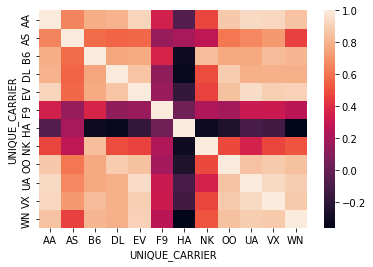

In [ ]:
# 11) pivot table: for each carrier and for each weekday show the number of departed flights;
# pairwise correlation among rows
pivot_table_count = ds.groupby(by=["UNIQUE_CARRIER", "FL_DATE"])["FL_NUM"].count()
pivot_table_count = pivot_table_count.reset_index().pivot(index="UNIQUE_CARRIER", columns="FL_DATE", values="FL_NUM").transpose()
correlation_matrix_count = pivot_table_count.corr(method='pearson')
sns.heatmap(correlation_matrix_count)

<AxesSubplot:xlabel='UNIQUE_CARRIER', ylabel='UNIQUE_CARRIER'>

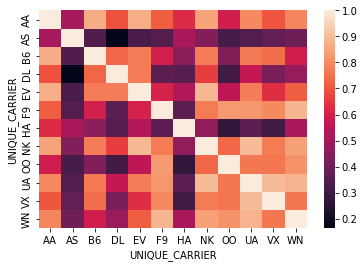

In [ ]:
# 12) 
pivot_table_mean = ds.groupby(by=["UNIQUE_CARRIER", "FL_DATE"])["ARR_DELAY"].mean()
pivot_table_mean = pivot_table_mean.reset_index().pivot(index="UNIQUE_CARRIER", columns="FL_DATE", values="ARR_DELAY").transpose()
correlation_matrix_mean = pivot_table_mean.corr(method='pearson')
sns.heatmap(correlation_matrix_mean)

<AxesSubplot:xlabel='weekday'>

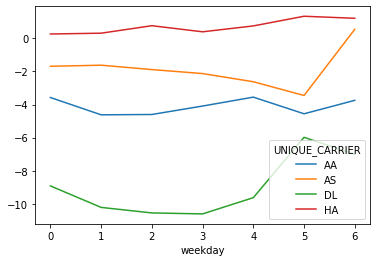

In [ ]:
# 13) 
MASK = (ds["UNIQUE_CARRIER"] =="HA") | (ds["UNIQUE_CARRIER"] == "DL") | (ds["UNIQUE_CARRIER"] == "AA") | (ds["UNIQUE_CARRIER"] == "AS")
pivot_table_mean_delta = ds.loc[MASK].groupby(by=["UNIQUE_CARRIER", "weekday"])["delaydelta"].mean()
pivot_table_mean_delta = pivot_table_mean_delta.reset_index().pivot(index="weekday", columns="UNIQUE_CARRIER", values="delaydelta")
pivot_table_mean_delta.plot(kind='line')